In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, autojit, prange
from scipy.ndimage.filters import convolve
from skimage.transform import rotate
import matplotlib.patches as mpatches
# Disable inline plots
#%matplotlib qt

In [2]:
# Does a 1D ft, doesn't need to be rolled over
@jit
def ft(signal):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(signal)))
# Fourier transform 2D slices of an image
@jit
def ft_slices(data):
    shape = np.shape(data) # Get shape of input data
    fslices = np.zeros(shape, dtype = np.complex_) # Array of complex zeros with same shape as input data
    l1 = shape[0] # Number of 2D slices through 3D volume
    for i in range (0, l1):
        fslices[i] = ft(data[i]) # Assign FT of individual slices to corresponding slice in zero array
        #print(i, end = ' ') # Testing counter printout
    return fslices
# Take FT of columns through 2D slices
@jit
def ft_columns(data):
    shape = np.shape(data) # Get shape of input data
    out = np.zeros(shape, dtype = np.complex_) # Array of complex zeros with same shape as input data
    l1 = shape[0] # Total number of loops for y dim
    l2 = shape[1] # Total number of loops for z dim
    for i in range (0, l1): # Loop through y
        for j in range (0, l2): # Loop through z
            out[:, i, j] = ft(data[:, i, j]) # Assign FT through x axis to corresponding region of zero array
        #print (i, end = ' ') # Testing counter printout
    return out
# Take 3D FT by taking FT of 2D slices through an image and then 1D columns perpendicular to slices
@jit
def ft_3d(data):
    slices = ft_slices(data)
    cols = ft_columns(slices)
    return cols
# Generates a gaussian window centered in the image with given input sigma
# Pixels in image are mapped from -2 to 2
# Does not drop off to 0 at edges, maybe fix, probably doesn't actually matter
def gauss_win_3d(width, sigma):
    rng = 2
    x, y, z = np.meshgrid(np.linspace(-rng,rng,width), np.linspace(-rng,rng,width), np.linspace(-rng,rng,width))
    d = np.sqrt(x*x+y*y+z*z) # generate matrix of distances
    mu = 0 # Make gaussian centered in image
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) ) # Map gaussian over distance matrix
    #cent = np.int(np.ceil(width/2)) # Get center row 
    #minval = np.min(g[cent]) # Get minimum value from center row of image
    #g = np.subtract(g, minval) # Subtract minimum value from gaussian image to shift ends to zero
    #g[g < 0] = 0 # Set any negative values in gaussian mask to 0
    
    return g
# Pad dataset before filter based on window provided
# Give data set (d_set), and window width (x)
# Needs numpy as np
@jit
def winpad(d_set, x):
    if (x % 2 == 0): # Check if window is even
        raise Exception('Window width must be odd!')
    rad = np.int(np.floor(x/2)) # Calculate radius of window given
    pad = np.pad(d_set, rad, 'edge')
    return pad
# Bragg peaks are located as outliers in some moving window
# Outliers are defined as values more than 3sigma away from the median
# Sigma is estimated using 1.4826*MAD
# Returns median+2.2*MAD of window for values detected to be outliers
# Input dataset (dset) and window width (x)
# Input an odd window or the window will be asymmetric and stuff breaks
from numba import autojit, prange
@jit(parallel=True)
def KAREN(d_set, width):
    if (width % 2 == 0): # Check if window is even
        raise Exception('Window width must be odd!')
    shape = np.shape(d_set) # Get shape of input data set
    out = np.zeros(shape) # Generate set of zeros same shape as input data set
    # Remove nans from center of image
    # This might not actually be necessary
    rad = (shape[0]/2)*0.1 # Radius for center region to remove nans from, ~10% of total volume width
    a, b = shape[0]/2-rad, shape[0]/2+rad # Bounds for center region to remove nans
    a=int(a) # Change to int values
    b=int(b) 
    d_set[a:b, a:b, a:b] = np.nan_to_num(d_set[a:b, a:b, a:b]) # Remove nans from center of volume
    x_pos, y_pos, z_pos = np.where(np.isfinite(d_set)) # Get location of finite values (pixels to be filtered)
    # Remove nans and very large positive/negative values before filtering
    d_set = np.nan_to_num(d_set)
    d_set[d_set>1e+100]=0
    d_set[d_set<1e-100]=0
    # Create padded data set to avoid windowing issues with values at edge
    temp = winpad(d_set, width)
    # Get loop length by taking length of list of pixels to be filtered
    length = len(x_pos)
    # Apply filter over pixels
    for i in prange (0, length):
        x, y, z = x_pos[i], y_pos[i], z_pos[i]
        # Outlier detection, basically the same as is_outlier_mm function
        # Only here to reduce overhead from function calls
        dat = temp[x:x+width, y:y+width, z:z+width]
        val = d_set[x, y, z]
        med = np.median(dat) # Get median of input data set
        mean = np.mean(dat) # Get mean of input data set
        mad = np.median(np.abs(dat- med)) # Get median absolute deviation
        asigma = np.abs(mad*3*1.4826) # Absolute value of approximate sigma
        if (med-asigma) < val < (med+asigma): # Check if value is outlier based on MAD
            out[x, y, z] = val # Return value if it is not an outlier
            continue
        else:
            out[x, y, z] = med+(2.2*mad) # Return median+2.2*MAD if value is outlier
            continue
    
    return out

In [3]:
# Create gaussian window
g = gauss_win_3d(401, 0.85)
# g = np.load('gaussian window function.npy')
# Load diffraction data
dcbr = np.load('Doped CBr4_symm_225.npy')
# Multiply by window function
dcbr = np.multiply(dcbr, g)
del g

In [4]:
# Remove bragg peaks from diffraction volume, window size chosen arbitrarily for now
kdcbr = KAREN(dcbr, 7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


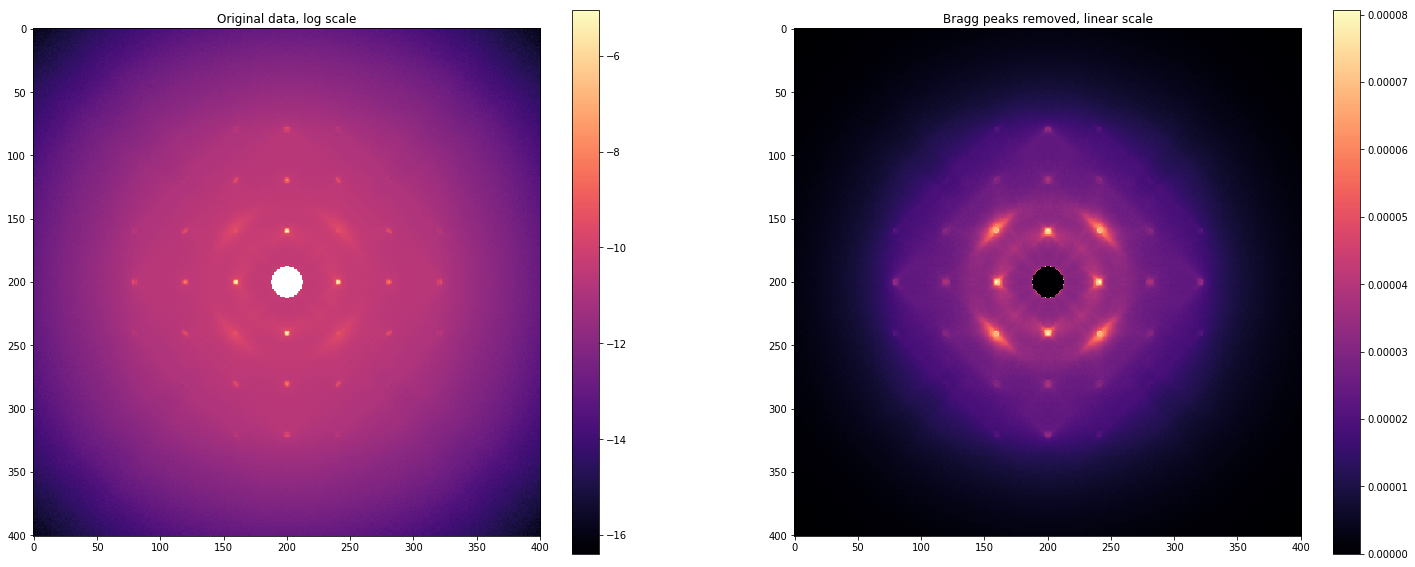

In [5]:
# 2D slice through 3D diffraction volume with bragg peaks removed
# Should only contain diffuse/diffuse from modulated peaks
plt.rcParams['figure.figsize'] = [25, 10]
plt.subplot(1, 2, 1)
plt.title('Original data, log scale')
plt.imshow(np.log(dcbr[201]), cmap = 'magma')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Bragg peaks removed, linear scale')
plt.imshow(kdcbr[201], cmap = 'magma')
plt.colorbar()

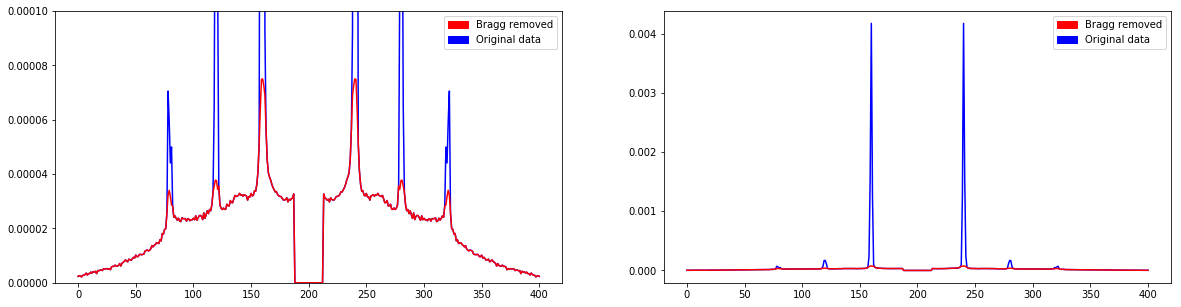

In [14]:
# 1-D Slice through bragg peaks
a = kdcbr[201][201] # Data with removed peaks
b = dcbr[201][201] # Original data

plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1,2,1)
plt.plot(b, 'b', a, 'r')
plt.ylim(0, 0.0001)
red_patch = mpatches.Patch(color = 'red', label = 'Bragg removed')
blue_patch = mpatches.Patch(color = 'blue', label = 'Original data')
plt.legend(handles = [red_patch, blue_patch], loc = 1)

plt.subplot(1,2,2)
plt.plot(b, 'b', a, 'r')
red_patch = mpatches.Patch(color = 'red', label = 'Bragg removed')
blue_patch = mpatches.Patch(color = 'blue', label = 'Original data')
plt.legend(handles = [red_patch, blue_patch], loc = 1)

plt.show()

In [16]:
ftdcbr = ft_3d(kdcbr)
# Generate mask to remove huge positive value in center
mask = np.ones((401,401,401))
mask[198:203, 198:203, 198:203] = 0
# Mask 3D pdf, throw out imaginary components
ftdcbr = np.multiply(np.real(ftdcbr), mask)

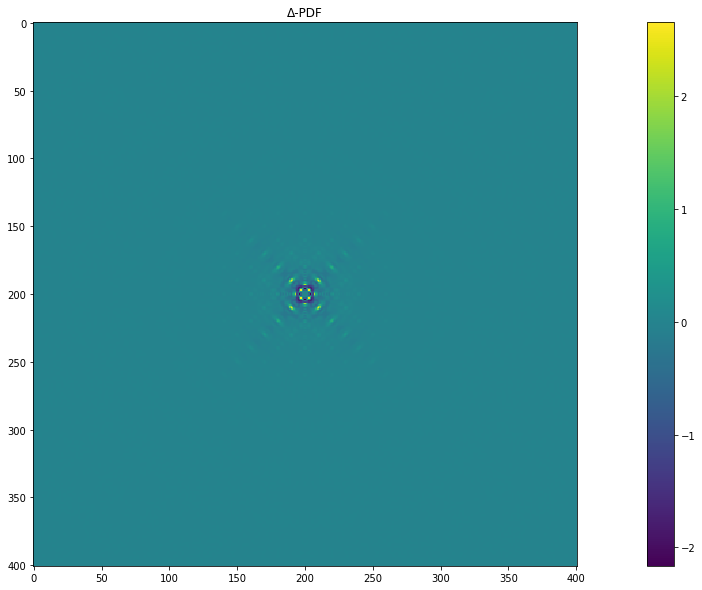

In [18]:
plt.rcParams['figure.figsize'] = [25, 10]
plt.imshow(ftdcbr[200], cmap = 'viridis')
plt.title('Δ-PDF')
plt.colorbar()

In [31]:
np.save('Doped CBr4, delta-pdf.npy', ftdcbr)